## Network Flow optimization
For this exercise, we will use CVXPY which is a Python-embedded modeling language for convex optimization problems. It allows to express problems in a natural way that follows the math, rather than in the restrictive standard form required by solvers (Matlab has the equivalent CVX).

If CVXPY is not already in your environment, you can install it following the instructions reported [here](https://www.cvxpy.org/install/index.html). (for Anaconda in Windows run in your notebook the command **conda install -c conda-forge cvxpy**)

Separable convex network flow optimization arises in several applications, e.g., shortest paths between origin and destination, system optimum traffic flows, user optimum network flows in homogeneous routing games, electrical current flows in resistor networks.

Given a multigraph $(V,E)$, an **exogenous network flow** is a vector ${\nu} \in \mathrm{R}^V$ such that

\begin{equation}
	\sum_{i \in V} \nu_i = 0.
\end{equation}

A network flow is a vector $f \in \mathrm{R}^E$ satisfying a positivity constraint and a mass conservation constraints, i.e.,

\begin{equation}
 f \ge \mathbf{0}, \quad Bf = \nu.
\end{equation}

Every edge is endowed with a separable non-decreasing convex cost function $\psi_e(f_e)$ such that $\psi_e(0)=0$. 

Given an exogenous flow $\nu$ and a network with node-edge matrix $B$, we study the following optimization problem:

\begin{equation}
\begin{aligned}
	f^* \in \ & \underset{\substack{f \in \mathrm{R}^{E}_+ \\ B f = \nu}}{\arg\min}
	& & \sum_{e \in E} \psi_e (f_e).
\end{aligned}
\end{equation}

The ratio $\psi_e(f_e) / f_e$ may be interpreted as the cost per unit of flow sent along the edge $e$. The convexity of $\psi_e(f_e)$ is thus equivalent to requiring that the marginal cost for sending some flow on each edge is non-decreasing in the flow itself.

This class of problems may be applied for shortest paths algorithms in a two-terminal network with origin and destination $(o,d)$. For instance:
- if $\psi_e(f_e) = f_e$, the cost for a unit of flow is 1, which means that all the edges have same length 1, and the cost paid for sending flow along an edge is simply proportional to the flow $f_e$ itself;
- if $\psi_e(f_e) = l_e f_e$, each edge is endowed with a length $l_e$ which differs from edge to edge. Even in this formulation, the cost for sending a unit of flow on the edge $e$ does not depend on $f_e$, which means that congestion effects are not taken into account. Congestion effects appear when considering strictly convex cost functions.

### Example 

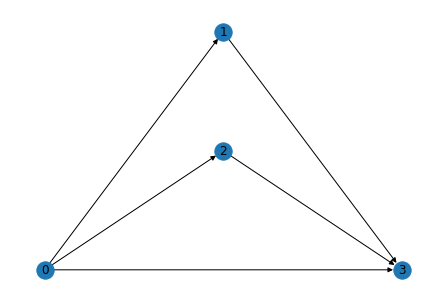

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()

G.add_edges_from([(0,1),(0,2),(0,3),(1,3),(2,3)])

pos = {0:[0,0], 1:[1,2], 2:[1,1], 3:[2,0]}

nx.draw(G, pos, with_labels=True)

We now use network flow optimization to find the shortest path from 0 to 3.

Since the problem is linear, the solution will be to allocate the flow on a convex combination of the optimal paths. The optimal paths can be thus deduced from the non-zero components of the optimal flow.

Assign to each link the same length.

In [2]:
import cvxpy as cp

# Problem data.

# incidence_matrix(G, oriented=True).toarray() returns  
# the incidence matrix of G as a numpy array. 
# In the matrix returned by incidence_matrix 
# a -1 appears for the source (tail) of an edge 
# and +1 for the destination (head) of the edge.
# This sign convention is opposite to the one we adopt
# for the node-link incidence matrix, so we 
# add a minus sign in front.
B = - nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).toarray() 
n_edges = len(G.edges)
# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node

# HINT: double-check the matrix B to ensure that the order of nodes and links is as you expect

# the solution of the shortest path problem is actually independent on the throughput value because of the linearity
tau = 1
nu = np.array([1, 0, 0, -1]) * tau
# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
# In this case, the objective function is
l = np.array([1,1,1,1,1]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Optimal f:", f.value)

Optimal f: [7.25651387e-11 7.25651387e-11 1.00000000e+00 7.25651162e-11
 7.25651162e-11]


The following characterization may be used to individuate the shortest paths: if the flow on a path $p$ is positive (i.e., if the flow on all the edges that compose the path is positive), then $p$ is a shortest path.

Of course, the optimal path is $0-3$, which is the only component of $f^*$ greater than 0.

We can compute the shortest path where the links have different lenghts.

In [3]:
B = - nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).toarray() 
n_edges = len(G.edges)
# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
# the solution of the shortest path problem is actually independent on the throughput value because of the linearity
tau = 1
nu = np.array([1, 0, 0, -1]) * tau
# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
# In this case, the objective function is
l = np.array([1,1,3,1,1]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Optimal f:", f.value)

Optimal f: [4.99999998e-01 4.99999998e-01 3.85901718e-09 4.99999998e-01
 4.99999998e-01]


If the edge $0-3$ has length 3, the shortest paths become $0-1-3$ and $0-2-3$.

This can be used for instance to compute the diameter of a network, the average distance between the nodes, and so on.

However, this is not the most efficient way to do this, and usually NetworkX has built-in functions that do this without using convex optimization.

# Traffic applications with congestion

## Pigou's example

Pigou was the first to illustrate the role of externality in users' choices, and the difference between user optimum and system optimum flow distributions.

We consider the traffic network with delay functions shown in figure below, which is assumed to
have a unit exogenous inflow at node o and a unit exogenous outflow at node d.

![figure](pigou.png)


1.  Determine the social (system) optimum flow distribution using CVXPY. The social optimum flow distribution is defined as the one minimizing the total delay $\sum_{e\in \mathcal{E}} \psi_e(f_e)$, where on every link $e \in \mathcal{E}$, the cost is $\psi_e(f_e) = f_e d_e(f_e)$ with $d_e(f_e)$ being the delay function. (note that if $d_e(f_e)$ is constant, i.e., if there is no congestion, the problem reduces to finding the shortest path)
2. Determine the user optimum flow (Wardrop equilibrium) using CVXPY.
3. Find tolls to align user optimum to social optimum.

### Solution

1.  **Compute social optimum flows and cost.** The social optimum of the network flow problem can be computed with CVXPY using the following code.

In [4]:
import numpy as np

# Problem data.

# compute node_edge incidence matrix
# +1 if the node is the source (tail) of an edge 
# and -1 if it is the destination (head) of the edge.
B = np.array([[1, 1],[-1,-1]])
n_edges = B.shape[1]

# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
nu = np.array([1, -1])
# Q and l store the coefficients of the quadratic
# and linear terms of the objective function.
# In this case, the objective function is
# f_1^2 + f_2
Q = np.diag([1,0]) # diagonal matrix
l = np.array([0,1]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(cp.quad_form(f,Q) + l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()
# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)

Social optimal flow: [0.5 0.5]
Optimal cost: 0.75


The obtained flow vector is $f = (1/2, 1/2)'$, with associated optimal cost 3/4.

2.  **Compute Wardrop equilibrium.** 

**Definition**: The Wardrop equilibrium is a path flow distribution such that if a path is used, then the cost of the path is minimal, i.e.,

$$
z_p>0 \implies c_p(z) \le c_r(z), \quad \forall \ r \in \mathcal{P},
$$

where $\mathcal{P}$ is the path set, $f=Az$ is the projection of the path flow on the link set, and $c_p(z) = \sum_{e: e \in p} d_e(f_e)$, i.e., the cost of a path is the sum of the delays that compose the path.

Ww say that $f$ is a Wardrop equilibrium if it is induced by a Wardrop equilibrium $z$ via $f=Az$.

**Theorem**: the flow vector $f^{(0)}$ corresponding to a Wardrop equilibrium can be obtained as a solution of a network flow optimization given that the cost functions $\psi_e(f_e)$ are chosen as
$$
\psi_e(f_e) = \int_0^{f_e} d_e(s)~\mathrm{d}s.
$$
For our problem, the objective function is
$$
\frac{f_1^2}{2}+f_2
$$

In [5]:
B = np.array([[1, 1],[-1,-1]])
n_edges = B.shape[1]

# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
nu = np.array([1, -1])
# Q and l store the coefficients of the quadratic
# and linear terms of the objective function.
Q = np.diag([1/2,0]) # diagonal matrix
l = np.array([0,1]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
cp.quad_form(f,Q)
objective = cp.Minimize(cp.quad_form(f,Q) + l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result_w = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop equilibrium:", f.value)

Wardrop equilibrium: [1.00000000e+00 2.74983778e-24]


Note that the social cost under Wardrop equilibrium is not the solution of the optimization problem above. It is

$$
\sum_{e}f_e^{(0)}d_e(f_e^{(0)}),
$$
where 

\begin{equation}
\begin{aligned}
	f^{(0)} \in \ & \underset{\substack{f \in \mathrm{R}^{E}_+ \\ B f = \nu}}{\arg\min}
	& & \sum_{e \in E} \int_{0}^{f_e} d_e (s) ds.
\end{aligned}
\end{equation}
is the Wardrop equilibrium of the game, namely the total travel time at the equilibrium.

This observation immediately implies that the price of anarchy cannot be less than 1.

In [6]:
def cost(f):
    return f[0]*f[0]+f[1] # compute the social cost (total travel time) (f_1)^2+f_2

cost_w = cost(f.value) # evaluate the social cost at the Wardrop equilibrium

print("Wardrop cost:", cost_w)

Wardrop cost: 1.0


We can compute the price of anarchy, which is the ratio between the Wardrop cost and the optimal cost.

In [7]:
PoA = cost_w/cost_opt

print("The price of anarchy:", PoA)

The price of anarchy: 1.3333333333333333


**Theorem** [Roughgarden et al., 2006] The maximum price of anarchy achievable with affine delay functions is 4/3.

Thus, this simple example achieves the maximum possible price of anarchy!

![figure](pigou.png)

In other words, what is the price of anarchy? 

- Assume that users' choices are imposed by a central planner. The flow distribution emerging from this centralized decision scheme is the social optimum flow distribution.
- In contrast with this, assume that users are free to choose their path based on other users' choices. The flow distribution emerging from this uncoordinated selfish behaviour is the Wardrop equilibrium, in which every user uses a path with minimal delay.

Note indeed that under system optimum flow distribution $(1/2, 1/2)$, the cost associated to each path (in this case, links) are

$$
d_1(1/2) = 1/2, \qquad d_2(1/2) = 1,
$$

thus an agent that is using the edge 2, if free to choose, will switch to edge 1.

There are two ways to improve the performance of the network:
- the first one is to improve the infrastructure (e.g., improving the delay functions of the links, or adding new links), which is called \emph{network design problem};
- the second way is to influence the agents' behaviour, in such a way to align user optimum flows with social optimum flows and reduce the inefficiency due to uncoordinated behaviour of the agents. This can be done in practice by information design, or adding tolls to the links of the network, which is the subject of the next part.

### How to add tolls: marginal tolls
The property of Wardrop equilibrium is that the cost of each used path (link, in this case) is the same.

However, when switching from edge 2 to edge 1 (same argument may be applied to paths in more complicated networks), an infinitesimal agent produces a modification in the social cost which is

$$
(\psi_1(f_1))'-(\psi_2(f_2))' = d_1(f_1)+f_1 (d_1(f_1))' - d_2(f_2)-f_2 (d_2(f_2))',
$$

where $f_e (d_e(f_e))'$ is the derivative of the cost that the other users on edge $e$ will pay due to the addition of infinitesimal flow on edge $e$.

The idea of marginal tolls is that if a toll equal to $f_e^{*} (d_e(f_e^{*}))'$ is added to each link $e$ (where $f^{*}$ denotes the social optimum flow distribution), then selfish users should pay not only for their delay, but also for the cost that make other users pay due to their choice.

Thus, users minimize the cost that all the system pays for their choice, which leads to social optimum flows.

3. **Compute Wardrop equilibrium with tolls.** Computing the Wardrop equilibrium as in 2., but with the link delays $d_e(f_e)$ replaced by $\widehat{d}_e(f_e) = d_e(f_e) + \omega_e$, a CVXPY solution can be obtained by the following code:

In [8]:
B = np.array([[1, 1],[-1,-1]])
n_edges = B.shape[1]

# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
nu = np.array([1, -1])

# find marginal tolls: for each edge the toll equals f*_e d'_e(f_e*)
# for affine delays this reads f*_e + a_e
# in this case a = [1,0], thus...
omega = opt_flow * np.array([1,0])

# the objective function is the same as before, except for the tolls
l = l + omega

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(cp.quad_form(f, Q) + l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop equilibrium with tolls:", f.value)

Wardrop equilibrium with tolls: [0.5 0.5]


The resulting flow vector is $f^{(\omega)} = (1/2, 1/2)'$, which is also the social optimum flow, as expected.

## Braess' paradox

Braess' paradox occurs when improving the network, e.g., adding a link, leads to a higher social cost under Wardrop equilibrium, or equivalently, removing a link reduces the social cost under Wardrop equilibrium 

Let us see an example.

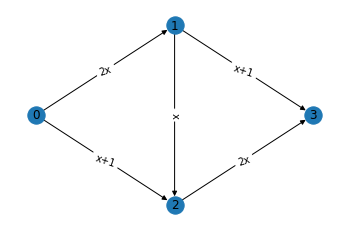

In [9]:
G = nx.DiGraph()

G.add_nodes_from([0,1,2,3])

G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(2,3)])

pos = {0:[0,0], 1:[2,1], 2:[2,-1], 3:[4,0]}

labels = ['2x','x+1','x','x+1','2x']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels=True)

Edge labels represent delay functions

**Social optimum flows**

In [10]:
B = -nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).toarray()
n_edges = len(G.edges)
# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
# the solution of the shortest path problem is actually independent on the throughput value because of the linearity
tau = 1
nu = np.array([1, 0, 0, -1]) * tau
# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
# In this case, the objective function is

Q = np.diag([2,1,1,1,2]) # diagonal matrix
l = np.array([0,1,0,1,0]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(cp.quad_form(f,Q) + l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Optimal flows:", f.value)
print("Optimal cost:", cost_opt)

Optimal flows: [5.00000000e-01 5.00000000e-01 2.93299946e-17 5.00000000e-01
 5.00000000e-01]
Optimal cost: 2.5


**Wardrop equilibrium**


In [11]:
B = -nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).toarray()
n_edges = len(G.edges)
# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
tau = 1
nu = np.array([1, 0, 0, -1]) * tau
# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
# In this case, the objective function is

Q = np.diag([1,1/2,1/2,1/2,1]) # diagonal matrix
l = np.array([0,1,0,1,0]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(cp.quad_form(f,Q) + l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop flows:", f.value)

Wardrop flows: [0.6 0.4 0.2 0.4 0.6]


In [12]:
# cost, defined as \sum_e f_e d_e(f_e)
def cost(f):
    return 2*f[0]*f[0]+f[1]*(f[1]+1)+f[2]*f[2]+f[3]*(f[3]+1)+2*f[4]*f[4]

cost_w = cost(f.value) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA)

Wardrop cost: 2.6000000000000005
The price of anarchy: 1.0400000000000003


Note that under optimal flows the link $e_3$ is not used, while under Wardrop equilibrium $e_3$ is used, and PoA>1.

This suggests that the inefficiency (since PoA>1) may be eliminated by removing the link $e_3$

Let's try!

The optimal flows are not affected by the removal $e_3$ (why?). Let's compute the Wardrop equilibrium of the new network. 

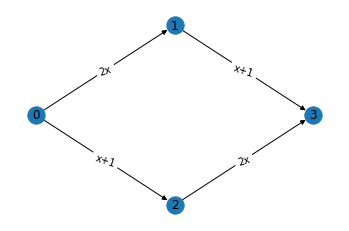

In [13]:
# G without $e_3$

G = nx.DiGraph()

G.add_nodes_from([0,1,2,3])

G.add_edges_from([(0,1),(0,2),(1,3),(2,3)])

pos = {0:[0,0], 1:[2,1], 2:[2,-1], 3:[4,0]}

labels = ['2x','x+1','x+1','2x']

zip_operator = zip(G.edges(), labels)
labels = dict(zip_operator)

nx.draw_networkx_edge_labels(G,pos,edge_labels = labels)

nx.draw(G, pos, with_labels=True)

In [14]:
B = -nx.linalg.graphmatrix.incidence_matrix(G, oriented=True).toarray()
n_edges = len(G.edges)

# exogenous flow vector: one unit of flow enters the origin and 
# exits the destination node
tau = 1
nu = np.array([1, 0, 0, -1]) * tau
# l stores the coefficients of the linear terms of the objective function, in this case the length of the links.
# In this case, the objective function is

Q = np.diag([1,1/2,1/2,1]) # diagonal matrix
l = np.array([0,1,1,0]) # 1d array

# Construct the problem.
f = cp.Variable(n_edges)
objective = cp.Minimize(cp.quad_form(f,Q) + l.T @ f)
constraints = [B @ f == nu, f >=0]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for f is stored in `f.value`.
print("Wardrop flows:", f.value)

Wardrop flows: [0.5 0.5 0.5 0.5]


In [15]:
# cost, defined as \sum_e f_e d_e(f_e)
def cost(f):
    return 2*f[0]*f[0]+f[1]*(f[1]+1)+f[2]*(f[2]+1)+2*f[3]*f[3]

cost_w = cost(f.value) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA)

Wardrop cost: 2.5
The price of anarchy: 1.0


The price of anarchy is minimized! 

This is an example of network design problem in which links are removed instead of added or improved, exploiting Braess' paradox. Braess' paradox has been observed also in reality, not only in theoretical examples.

The price of anarchy could be minimized also by adding marginal tolls, or by other toll patterns, e.g., by adding a large toll on link $e_3$ in such a way to prevent users to travel along that link.

### A sufficient conditions for PoA=1

**Observation**: assume that delay functions are linear, i.e., $d_e(f_e) = a_e f_e$. Then, 

$$
f_e d_e(f_e) = a_e f_e^2 = 2 \int_{0}^{f_e} d_e(s) ds,
$$

which implies that if the delay functions are linear, then user equilibria coincide with social optimum flows.

### Resistor networks
Network flow optimization can be adapted to many applications, for instance electrical flows in resistor networks.

In particular, social optimum traffic flows coincide with electrical current in a resistor network if:
- the delay functions are linear, i.e., $d_e(f_e) = a_e f_e$;
- the non-negativity constraint $f_e \ge 0$ is relaxed.

The coefficients $a_e$ have to be interpreted as the resistance of the link $e$, and the throughput $\tau$ as the electrical current injected in the network. It can also be proven that the Lagrangian multipliers associated to the mass conservation in the node set corresponds to electrical potential on the nodes of the resistor network. 